# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [35]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [36]:
# just for fun: to sketch out approximate run time for this notebook
import time  # for stopwatch and sleep
t1 = time.perf_counter()  # track execution time

In [37]:
# Set the random seed for reproducibility

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [38]:
# Load the fear and greed sentiment data for Bitcoin
file_btc_sent="C:/Users/CS_Knit_tinK_SC/Documents/GitHub/HW_11_DeepLrn_ML_Inputs_U14/Starter_Code/btc_sentiment_sorted.csv"
df = pd.read_csv(file_btc_sent, index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2018-01-02,30
2018-01-03,38
2018-01-04,16
2018-01-05,56
2018-01-06,24


In [39]:
# Load the historical closing prices for Bitcoin
file_btc_hist="C:/Users/CS_Knit_tinK_SC/Documents/GitHub/HW_11_DeepLrn_ML_Inputs_U14/Starter_Code/btc_historic.csv"
df2 = pd.read_csv(file_btc_hist, index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.head()

Date
2018-01-02    14754.129883
2018-01-03    15156.620117
2018-01-04    15180.080078
2018-01-05    16954.779297
2018-01-06    17172.300781
Name: Close, dtype: float64

In [40]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [41]:
df.head()

,fng_value,Close
2018-01-02,30,14754.129883
2018-01-03,38,15156.620117
2018-01-04,16,15180.080078
2018-01-05,56,16954.779297
2018-01-06,24,17172.300781


In [42]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [43]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [44]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]
split

347

In [45]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.


# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [46]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.82652746]
  [0.85540094]
  [0.85708389]
  [0.98439564]
  [1.        ]
  [1.        ]
  [1.        ]
  [0.96141088]
  [1.        ]
  [0.94974579]]

 [[0.85540094]
  [0.85708389]
  [0.98439564]
  [1.        ]
  [0.9322701 ]
  [0.90366082]
  [0.95677072]
  [1.        ]
  [0.86211745]
  [1.        ]]

 [[0.85708389]
  [0.98439564]
  [1.        ]
  [0.9322701 ]
  [0.84245597]
  [0.86459622]
  [0.99517359]
  [0.86211745]
  [0.90773495]
  [0.53148083]]] 

X_test sample values:
[[[0.02650901]
  [0.02435761]
  [0.02625649]
  [0.02513523]
  [0.02611158]
  [0.02559088]
  [0.01881099]
  [0.0158929 ]
  [0.02008217]
  [0.02212339]]

 [[0.02435761]
  [0.02625649]
  [0.02513523]
  [0.02611158]
  [0.02385761]
  [0.01699876]
  [0.01581619]
  [0.02008217]
  [0.02008217]
  [0.01900518]]

 [[0.02625649]
  [0.02513523]
  [0.02611158]
  [0.02385761]
  [0.01584743]
  [0.01429247]
  [0.01998525]
  [0.02008217]
  [0.01725167]
  [0.0215974 ]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [48]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5  # equals the time window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    # except for final layer, each time we add a new LSTM layer, we must set return_sequences=True
    # it just lets Keras know to connect each layer
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [49]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")


In [50]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 5)             140       
                                                                 
 dropout_3 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_4 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_5 (Dropout)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [25]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
347/347 [==============================] - 4s 4ms/step - loss: 0.0537
Epoch 2/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0301
Epoch 3/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0264A: 1s - los - ETA: 0s
Epoch 4/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0217
Epoch 5/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0145
Epoch 6/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 7/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 8/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0121A: 0s
Epoch 9/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0116
Epoch 10/10
347/347 [==============================] - 1s 4ms/step - loss: 0.0095


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [26]:
# Evaluate the model

model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 4ms/step - loss: 0.0372


0.03715919330716133

In [27]:
# Make some predictions
predicted = model.predict(X_test)

In [28]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
print(predicted[0:10])
print(predicted_prices[0:10])

[[0.04204877]
 [0.0411804 ]
 [0.04045995]
 [0.03964156]
 [0.03893149]
 [0.0382338 ]
 [0.03773406]
 [0.03767017]
 [0.03765219]
 [0.03750955]]
[[3678.592 ]
 [3669.3796]
 [3661.7368]
 [3653.0547]
 [3645.5217]
 [3638.1204]
 [3632.8186]
 [3632.1406]
 [3631.9502]
 [3630.437 ]]


In [30]:
# Create a DataFrame of Real and Predicted values  (#01c kind of also)
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
2019-02-01,3434.129883,3678.592041
2019-02-02,3461.629883,3669.379639
2019-02-03,3508.679932,3661.736816
2019-02-04,3449.620117,3653.054688
2019-02-05,3431.239990,3645.521729


<AxesSubplot:title={'center':'Closing Price data: Real vs Predicted values'}>

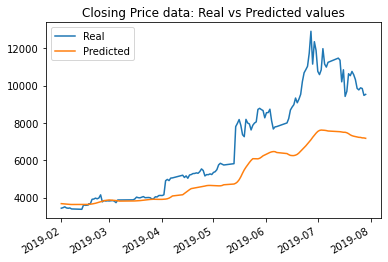

In [33]:
# Plot the real vs predicted values as a line chart
stocks.plot(title='Closing Price data: Real vs Predicted values')

In [32]:
# time estimate.. just to keep an eye on such aspects a little bit!
t2 = time.perf_counter()
execution_time = t2 - t1
print("execution time: " + str(round(execution_time, 1)) + " seconds")

execution time: 108.9 seconds
